# Simulating Trust Bonus on cadCAD

> *Danilo Lessa Bernardineli, October 2023*

This model is a subset of the Neural Quorum Governance model as in https://github.com/BlockScience/neural-quorum-governance/tree/main

## Part 1: Pre-requisites

In [1]:
from dataclasses import dataclass
from functools import reduce
from typing import Annotated, TypedDict, Union, Callable
from cadCAD_tools.types import *
from cadCAD_tools.execution import easy_run
from random import random, normalvariate, seed
from copy import deepcopy, copy
from functools import reduce
from enum import Enum, auto
import pandas as pd
import colorsys
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from netgraph import Graph
pio.renderers.default = "png" # For GitHub rendering

## Part 2. Module Logic

### Model Types & Classes

In [2]:
UserUUID = int
Days = Annotated[float, 'days']  # Number of days
UserUUID = str
TrustGraph = dict[UserUUID, set[UserUUID]]
VotingPower = float

@dataclass
class User():
    label: UserUUID

@dataclass
class OracleState():
    pagerank_results: dict[UserUUID, float]


### Model State & Parameter Space definition

In [3]:
class TBModelState(TypedDict):
    days_passed: Days
    delta_days: Days
    users: list[User]
    trustees: TrustGraph
    oracle_state: OracleState


class TBModelParams(TypedDict):
    label: str

    # Behavioral Parameters
    avg_new_users_per_ts: float
    new_user_average_trustees: float


### Auxiliary Logic

In [4]:
def trust_score(user_id: UserUUID, oracle_state: OracleState) -> VotingPower:
    """
    Computes the Trust Score as based on the Canonical Page Rank.

    This is done by computing the Page Rank on the whole Trust Graph
    with default arguments and scaling the results through MinMax.

    The resulting scores will be contained between 0.0 and 1.0
    """
    pagerank_values = oracle_state.pagerank_results
    if (len(pagerank_values)) < 2 or (user_id not in pagerank_values.keys()):
        trust_score = 0.0
    else:
        value = pagerank_values[user_id]
        max_value = max(pagerank_values.values())
        min_value = min(pagerank_values.values())
        if max_value == min_value:
            # XXX: assumption for edge cases
            trust_score = 0.5
        else:
            trust_score = (value - min_value) / (max_value - min_value)
    return trust_score

def retrieve_prev_state_users(history):
    if len(history) > 1:
        previous_state_users = set(u.label 
                                for u 
                                in history[-1][-1]['users'])
    else:
        previous_state_users = set()
    return previous_state_users

### Model Block Logic Definitions

In [5]:
from cadCAD_tools.types import Signal, VariableUpdate  # type: ignore
from typing import Callable
from copy import deepcopy
from scipy.stats import poisson, bernoulli  # type: ignore
from random import choice, sample
import networkx as nx # type: ignore

def generic_policy(_1, _2, _3, _4) -> dict:
    """Function to generate pass through policy

    Args:
        _1
        _2
        _3
        _4

    Returns:
        dict: Empty dictionary
    """
    return {}


def replace_suf(variable: str, default_value=0.0) -> Callable:
    """Creates replacing function for state update from string

    Args:
        variable (str): The variable name that is updated

    Returns:
        function: A function that continues the state across a substep
    """
    return lambda _1, _2, _3, state, signal: (variable, signal.get(variable, default_value))


def add_suf(variable: str, default_value=0.0) -> Callable:
    """Creates replacing function for state update from string

    Args:
        variable (str): The variable name that is updated

    Returns:
        function: A function that continues the state across a substep
    """
    return lambda _1, _2, _3, state, signal: (variable, signal.get(variable, default_value) + state[variable])



def p_evolve_time(params: TBModelParams, _2, _3, _4) -> Signal:
    return {'delta_days': params['timestep_in_days']}

def s_days_passed(_1, _2, _3,
                  state: TBModelState,
                  signal: Signal) -> VariableUpdate:
    return ('days_passed', state['days_passed'] + signal['delta_days'])

def s_delta_days(_1, _2, _3, _4, signal: Signal) -> VariableUpdate:
    return ('delta_days', signal['delta_days'])


def s_onboard_users(params: TBModelParams, _2, _3, state: TBModelState, _5) -> VariableUpdate:
    """
    Onboard N new users and their relevant properties for NG
    through stochastic processes.
    """
    new_user_list = deepcopy(state['users'])

    avg_new_users_per_ts = params['avg_new_users_per_ts']
    new_users: int = poisson.rvs(avg_new_users_per_ts)

    for i in range(new_users):
        new_user = User(label=len(new_user_list) + i)
        new_user_list.append(new_user)

    return ('users', new_user_list)


def s_trust(params: TBModelParams, _2, history, state: TBModelState, _5) -> VariableUpdate:
    """
    Make new users trust each other

    XXX: this is done by randomly sampling the set of previous users. The amount
    of users to be trusted is sampled from a Poisson distribution.
    """
    trustees: TrustGraph = deepcopy(state['trustees'])
    current_users = set(u.label 
                     for u 
                     in state['users'])
    
    previous_state_users = retrieve_prev_state_users(history)

    new_users = current_users - previous_state_users
    for user in new_users:
        n_user_trustees = poisson.rvs(params['new_user_average_trustees'])
        n_user_trustees = min(n_user_trustees, len(previous_state_users))
        user_trustees = set(sample(previous_state_users, n_user_trustees))
        trustees[user] = user_trustees

    return ('trustees', trustees)

def s_oracle_state(params: TBModelParams, _2, _3, state: TBModelState, _5) -> VariableUpdate:
    """
    Update the state of the oracles (eg. pagerank values & oracles/reputation weights)
    """
    raw_graph = state['trustees']

    # Update Page rank values
    G = nx.from_dict_of_lists(raw_graph,
                              create_using=nx.DiGraph)
    pagerank_values = nx.pagerank(G, 
                                  alpha=0.85, 
                                  personalization=None, 
                                  max_iter=100,
                                  tol=1e-6,
                                  nstart=None,
                                  weight=None,
                                  dangling=None)
    
    # Update Reputation & Prior Voting user data

    new_state = OracleState(pagerank_results=pagerank_values)
    return ('oracle_state', new_state)


### Model Block Structure Definitions

In [6]:
from copy import deepcopy


NG_MODEL_BLOCKS: list[dict] = [
    {
        'label': 'Onboard users',
        'policies': {},
        'variables': {
            'users': s_onboard_users
        }
    },
    {
        'label': 'Trust & Vote',
        'policies': {
        },
        'variables': {
            'trustees': s_trust,
        }
    },
    {
        'label': 'Update Oracle State',
        'policies': {},
        'variables': {
            'oracle_state': s_oracle_state
        }
    }
]


NG_MODEL_BLOCKS = [block for block in NG_MODEL_BLOCKS
                              if block.get('ignore', False) is False]

# Post Processing

blocks: list[dict] = []
for block in [b for b in NG_MODEL_BLOCKS if b.get('ignore', False) != True]:
    _block = deepcopy(block)
    for variable, suf in block.get('variables', {}).items():
        if suf == add_suf:
            _block['variables'][variable] = add_suf(variable)
        elif suf == replace_suf:
            _block['variables'][variable] = replace_suf(variable)
        else:
            pass
    blocks.append(_block)

NG_MODEL_BLOCKS = deepcopy(blocks)

## Part 3. cadCAD Simulation

### Simulation Initial State & Parameters

In [7]:
from numpy import nan

TIMESTEPS = 100
SAMPLES = 1

N_INITIAL_USERS = 6

INITIAL_ORACLE_STATE = OracleState(
    pagerank_results={}
)

INITIAL_STATE = TBModelState(
    days_passed=0.0,
    delta_days=nan,
    users=[],
    trustees={},
    oracle_state=INITIAL_ORACLE_STATE
)

SINGLE_RUN_PARAMS = TBModelParams(
    label='default_run',
    avg_new_users_per_ts=1.0,
    new_user_average_trustees=7.0
)

## Part 4. Results

In [8]:
default_run_args = (INITIAL_STATE,
                     {k: [v] for k, v in SINGLE_RUN_PARAMS.items()},
                    NG_MODEL_BLOCKS,
                    TIMESTEPS,
                    SAMPLES)
sim_df = easy_run(*default_run_args, assign_params=False).set_index('timestep')


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 3, 1, 5)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 3, 1, 5)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: local_simulations
Execution Mode: single_threaded


/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_36845/4182208875.py:95: DeprecationWarning:

Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.



Flattening results:   0%|          | 0/301 [00:00<?, ?it/s]

Total execution time: 0.49s


In [9]:
sim_df.head(5)

,days_passed,delta_days,users,trustees,oracle_state,simulation,subset,run
timestep,,,,,,,,
0,0.0,NaN,[],{},OracleState(pagerank_results={}),0,0,1
1,0.0,NaN,[User(label=0)],{0: {}},OracleState(pagerank_results={0: 1.0}),0,0,1
2,0.0,NaN,"[User(label=0), User(label=1)]","{0: {}, 1: {0}}",OracleState(pagerank_results={0: 0.64912263806...,0,0,1
3,0.0,NaN,"[User(label=0), User(label=1)]","{0: {}, 1: {0}}",OracleState(pagerank_results={0: 0.64912263806...,0,0,1
4,0.0,NaN,"[User(label=0), User(label=1), User(label=2), ...","{0: {}, 1: {0}, 8: {0, 1}, 2: {0, 1}, 4: {0, 1...",OracleState(pagerank_results={0: 0.42710568203...,0,0,1


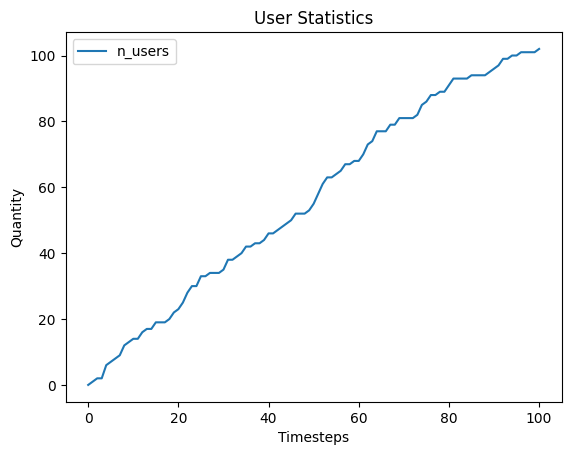

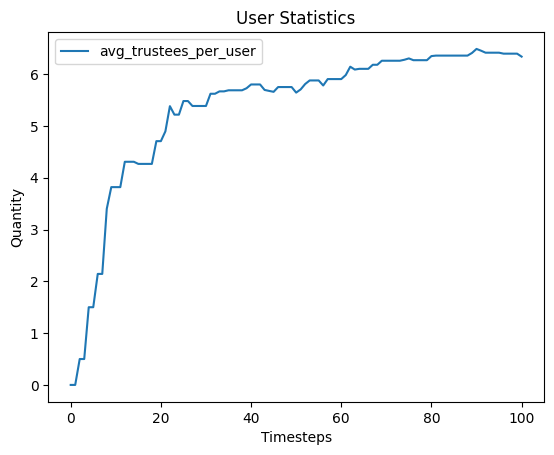

In [10]:
# Global metrics

metrics = {
    'n_users': lambda row: len(row.users),
    'avg_trustees_per_user': lambda row: sum(len(l) for l in row.trustees.values()) / len(row.trustees) if len(row.trustees) > 0 else 0.0,
}



new_df = sim_df.apply(metrics.values(), axis='columns')
new_df.columns = list(metrics.keys())

new_df[['n_users']].plot(xlabel='Timesteps', ylabel='Quantity', title='User Statistics')
plt.show()

new_df[['avg_trustees_per_user']].plot(xlabel='Timesteps', ylabel='Quantity', title='User Statistics')
plt.show()

In [11]:
def render_trust_graph(i):
    t = sim_df.iloc[i].name
    trust_graph_per_day = sim_df.trustees.map(nx.DiGraph)

    def sample_colors_from_hue(N):
        import colorsys
        HSV_tuples = [(x*1.0/N, 1.0, 0.8) for x in range(N)]
        RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
        return list(RGB_tuples)

    cmap = matplotlib.colormaps['BrBG']

    def render_graph(G, 
                    weights,
                    K=1, 
                    q=1, 
                    title="", 
                    a=1, 
                    node_color=None,
                    edge_color=None,
                    edge_alpha=0.5,
                    edge_width=0.1,
                    **kwargs):
        sizes = {k: a + K * v ** q for k, v in weights.items()}
        if node_color is None:
            node_color = {k: cmap(i / len(weights)) for i, k in enumerate(sorted(weights.keys()))}
        else:
            pass
        fig = plt.figure(figsize=(10, 2), dpi=200) 
        ax = fig.add_subplot(1, 1, 1)
        g = Graph(G, 
                ax=ax,
                node_size=sizes,
                node_edge_width=0,
                edge_width=edge_width,
                node_color=node_color,
                edge_alpha=edge_alpha,
                edge_color=edge_color,
                **kwargs)
        ax.set_facecolor(colorsys.hsv_to_rgb(0.0, 0.0, 0.9))
        fig.set_facecolor(colorsys.hsv_to_rgb(0.0, 0.0, 0.9))
        plt.title(title, fontname='Helvetica')
        plt.show()


    G = trust_graph_per_day.iloc[i]
    weights = sim_df.iloc[i].oracle_state.pagerank_results
    render_graph(G, 
                weights, 
                K=20, 
                q=0.5, 
                a=0, 
                title=f"Trust Graph at timestep {t:.0f}",
                edge_layout='curved',
                node_layout='spring',
                edge_width=0.1,
                arrows=True,
                scale=(4,1))

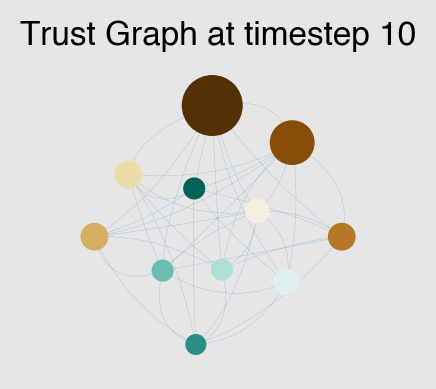

In [12]:
render_trust_graph(10)

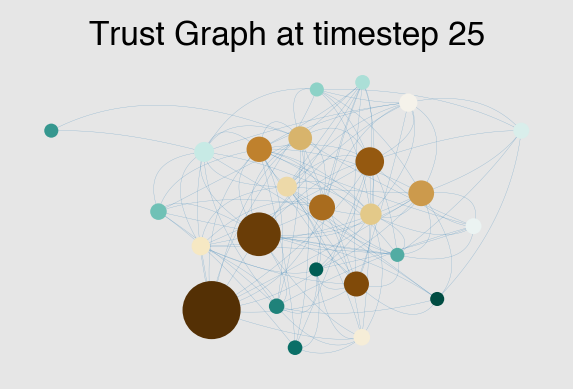

In [13]:
render_trust_graph(25)

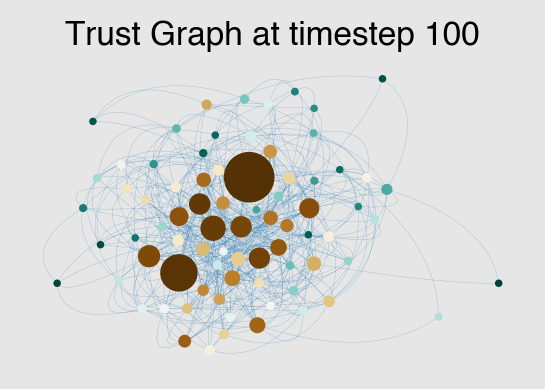

In [14]:
render_trust_graph(100)